In [237]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [258]:
# Loading data
measures = pd.read_csv("../data/measures_database.csv", sep=';', encoding='utf8')
stock_it = pd.read_csv("../data/FTSE_MIB_large.csv", sep='\t', encoding='utf7')

In [259]:
# Cleaning
measures = measures.dropna(axis='rows', subset=['DATE_IMPLEMENTED'])
measures = measures.dropna(axis='columns', how='all')
measures['DATE_IMPLEMENTED'] = pd.to_datetime(measures['DATE_IMPLEMENTED'], dayfirst=True)

measures = measures[measures['LOG_TYPE'] != "Phase-out measure"] # Not looking at phasing out atm

measures.MEASURE = measures['MEASURE'].str.split().str.join(' ') # remove HTML \xa0
measures = measures[measures['MEASURE'] != 'Strengthening the public health system']
measures = measures[measures['MEASURE'] != 'Economic measures']
measures = measures[measures['MEASURE'] != 'Awareness campaigns']
measures = measures[measures['MEASURE'] != 'Psychological assistance and medical social work']
measures = measures[measures['MEASURE'] != 'Changes in prison-related policies']
measures = measures[measures['MEASURE'] != 'Other public health measures enforced']

measures.sort_values(by='DATE_IMPLEMENTED',ascending=True, inplace=True)


stock_it['Date'] = pd.to_datetime(stock_it['Date'])
stock_it.sort_values(by='Date',ascending=True, inplace=True)
stock_it.reset_index(inplace=True)

In [260]:
# Selecting
country_name = 'Italy'

measures_it = measures[measures['COUNTRY'] == country_name]
measures_it.reset_index(inplace=True)

In [261]:
def measure_to_binary(measures_country, stock_with_date, date_string):    
    binary_var_length = []
    for date in measures_country['DATE_IMPLEMENTED']:
        length = stock_with_date.index[stock_with_date[date_string] == date]
        if length.size != 0:
            binary_var_length.append(stock_with_date.index[stock_with_date[date_string] == date][0])
    result = []
    for i in range(len(binary_var_length)):
        result.append([0 for j in range(binary_var_length[i])] + [1 for k in range(stock_with_date.index.size-binary_var_length[i])])
        
    return result

In [262]:
measures_binary = measure_to_binary(measures_it, stock_it, "Date")

In [263]:
def print_tree_with_names(tree, column_names, indent):
    """Convert scikit learn GBT model tree into python code"""
    left      = tree.children_left
    right     = tree.children_right
    threshold = tree.threshold
    features  = [column_names[i] for i in tree.feature]
    value = tree.value
    depth = 0  

    def get_indent(depth, indent):
        s = ""
        for j in range(depth):
            s += indent
        return s    

    def recurse(left, right, threshold, features, node, depth):
        depth+=1
        text = []
        line_indent = get_indent(depth, indent)
        if (threshold[node] != -2):
            text += [line_indent + 'if row["%s"] <= %f:' % (features[node], threshold[node])]
            if left[node] != -1:
                text += recurse(left, right, threshold, features,left[node],depth)
            text += [line_indent + "else:"]
            if right[node] != -1:
                text += recurse(left, right, threshold, features,right[node],depth)
        else:
            text += [line_indent + 'score += %f' % value[node][0][0]]
        return text    
    
    return recurse(left, right, threshold, features, 0, 1)

In [264]:
def get_gbt_model_rules(gbt_model, column_names, k=None):
    """Export scikit learn GBT model rules to function"""
    if len(column_names) == 1:
        # duplication of the same feature name is needed if only 1 was used for GBT training!
        column_names = column_names*3
    INDENT = str("    ")
    num_of_trees = len(gbt_model.estimators_)
    
    if k!=None:
        num_of_trees = min(k, num_of_trees)    
    
    func_str = ["def score_gbt(eval_df, model_name):"]
    func_str += [INDENT + '"""Score segment by gbt rule"""']
    func_str += []
    func_str += [INDENT + "def score_by_gbt_tree_rule(row):"]
    func_str += [INDENT + '# GBT model generated by Scikit-Learn']
    func_str += [INDENT + INDENT + "score = 0.0",]
    
    for i in range(num_of_trees):
        func_str += [INDENT + INDENT + '### tree_%i ###' % (i+1)]
        func_str += print_tree_with_names(gbt_model.estimators_[i,0].tree_, column_names, INDENT)
        func_str += ['']
        
    func_str += [INDENT + INDENT + "return score"]
    func_str += []
    func_str += [INDENT + "eval_df['SCORE_'+model_name] = eval_df.apply(score_by_gbt_tree_rule, axis=1)"]
    func_str += [INDENT + "return eval_df"]
    
    return func_str

In [265]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit


n_est = 1
max_d = 15
measure_index = 10

X = stock_it.Price.values.reshape(-1,1)
y = np.asarray(measures_binary[measure_index]) # Select measure
column_names = ['stock']

n_splits = len(X)//20

tss = TimeSeriesSplit(n_splits=n_splits) 
for train_index, test_index in tss.split(X):
    X_train, X_test = X[train_index, :], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

model = GradientBoostingClassifier(learning_rate=0.15,n_estimators=n_est,max_depth=max_d)
model.fit(X_train, y_train)

get_gbt_model_rules(model, column_names)
# model.predict([[20000]])

['def score_gbt(eval_df, model_name):',
 '    """Score segment by gbt rule"""',
 '    def score_by_gbt_tree_rule(row):',
 '    # GBT model generated by Scikit-Learn',
 '        score = 0.0',
 '        ### tree_1 ###',
 '        if row["stock"] <= 18073.520508:',
 '            score += 17.611111',
 '        else:',
 '            if row["stock"] <= 18653.849609:',
 '                if row["stock"] <= 18403.450195:',
 '                    score += -1.060201',
 '                else:',
 '                    score += 17.611111',
 '            else:',
 '                score += -1.060201',
 '',
 '        return score',
 "    eval_df['SCORE_'+model_name] = eval_df.apply(score_by_gbt_tree_rule, axis=1)",
 '    return eval_df']

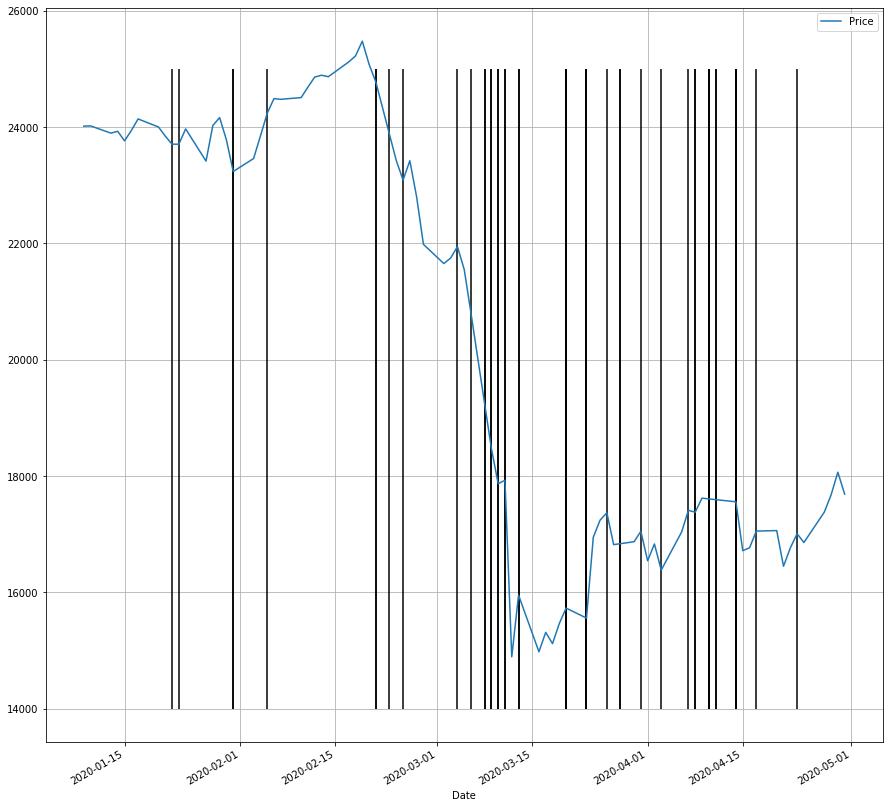

In [266]:
stock_red = stock_it[stock_it['Date'] > "2020-01-08"]
axes = stock_red.plot(x='Date', y="Price", grid=True, figsize = (15, 15), backend='matplotlib')
plt.vlines(x=measures_it['DATE_IMPLEMENTED'].values, ymin=14000, ymax=25000)

In [270]:
measures_it.MEASURE.values[measure_index]
# stock_it.Date
measures_it

,index,ID,COUNTRY,ISO,ADMIN_LEVEL_NAME,REGION,LOG_TYPE,CATEGORY,MEASURE,TARGETED_POP_GROUP,COMMENTS,NON_COMPLIANCE,DATE_IMPLEMENTED,SOURCE,SOURCE_TYPE,LINK,ENTRY_DATE,Alternative source
0,3802,2062,Italy,ITA,NaN,Europe,Introduction / extension of measures,Governance and socio-economic measures,Emergency administrative structures activated ...,No,Ministry task-force established,Not applicable,2020-01-22,Ministry of Health,Government,http://www.salute.gov.it/portale/nuovocoronavi...,24/03/2020,NaN
1,3788,1676,Italy,ITA,NaN,Europe,Introduction / extension of measures,Public health measures,Isolation and quarantine policies,No,The temperature of all travelers returning hom...,Not applicable,2020-01-23,Ministry of the Interior,Government,https://www.interno.gov.it/it/notizie/emergenz...,23/03/2020,NaN
2,3777,243,Italy,ITA,NaN,Europe,Introduction / extension of measures,Movement restrictions,International flights suspension,Yes,Limited flights to and from China,Not applicable,2020-01-31,Forbes,Media,https://www.forbes.com/sites/davekeating/2020/...,15/03/2020,http://www.salute.gov.it/portale/nuovocoronavi...
3,3776,242,Italy,ITA,NaN,Europe,Introduction / extension of measures,Governance and socio-economic measures,State of emergency declared,Yes,State of Emergency declared on the risks assoc...,Not applicable,2020-01-31,Government,Government,http://www.governo.it/it/articolo/coronavirus-...,15/03/2020,NaN
4,3863,7295,Italy,ITA,NaN,Europe,Introduction / extension of measures,Governance and socio-economic measures,Emergency administrative structures activated ...,No,Scientific Technical Committee established,Not applicable,2020-02-05,Ministry of Health,Government,http://www.salute.gov.it/portale/news/p3_2_1_1...,24/04/2020,NaN
5,3799,1687,Italy,ITA,NaN,Europe,Introduction / extension of measures,Public health measures,Isolation and quarantine policies,Yes,All people coming from China or other risk are...,Not applicable,2020-02-21,Ministry of Health,Government,http://www.salute.gov.it/portale/nuovocoronavi...,23/03/2020,http://www.salute.gov.it/portale/nuovocoronavi...
6,3779,423,Italy,ITA,NaN,Europe,Introduction / extension of measures,Social distancing,Schools closure,Yes,In all municipalities that are affected (case ...,Not applicable,2020-02-21,Government,Government,https://www.gazzettaufficiale.it/eli/id/2020/0...,16/03/2020,NaN
7,3800,1688,Italy,ITA,NaN,Europe,Introduction / extension of measures,Governance and socio-economic measures,Emergency administrative structures activated ...,Yes,State guidance: All regions at risk (specifica...,Not applicable,2020-02-23,Government,Government,https://www.normattiva.it/uri-res/N2Ls?urn:nir...,23/03/2020,NaN
8,3796,1684,Italy,ITA,NaN,Europe,Introduction / extension of measures,Social distancing,Limit public gatherings,No,"Closure of museums, cancelling of educational ...",Not available,2020-02-25,Ministry of the Interior,Government,https://www.interno.gov.it/it/notizie/coronavi...,23/03/2020,NaN
9,3797,1685,Italy,ITA,Caltanissetta,Europe,Introduction / extension of measures,Movement restrictions,Checkpoints within the country,Yes,Police controls implemented at hospital entran...,Not applicable,2020-03-04,Ministry of the Interior,Government,https://www.interno.gov.it/it/notizie/piu-cont...,23/03/2020,NaN
